In [1]:
import torch
import torchvision
from torch import nn
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image

# from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

In [2]:
p = torchvision.datasets.LFWPeople(root = './lfw_torch', image_set = 'funneled', download = True)

Files already downloaded and verified


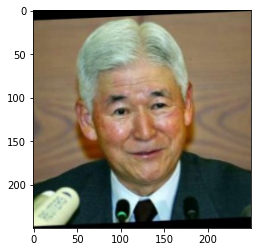

In [3]:
img = torchvision.io.read_image(p.data[6116]).numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))

In [4]:
len(p.data)

13233

In [5]:
'./lfw_torch\\lfw-py\\lfw-deepfunneled\\Jennifer_Aniston\\Jennifer_Aniston_0001.jpg' in p.data

False

In [6]:
s = './lfw_torch\\lfw-py\\lfw-deepfunneled\\Jennifer_Aniston\\Jennifer_Aniston_0018.jpg'

for i, x in enumerate(p.data):
    if x == s:
        print(i)

In [7]:
p.data[:5]

['./lfw_torch\\lfw-py\\lfw_funneled\\Abdel_Madi_Shabneh\\Abdel_Madi_Shabneh_0001.jpg',
 './lfw_torch\\lfw-py\\lfw_funneled\\Abdul_Rahman\\Abdul_Rahman_0001.jpg',
 './lfw_torch\\lfw-py\\lfw_funneled\\Abel_Pacheco\\Abel_Pacheco_0001.jpg',
 './lfw_torch\\lfw-py\\lfw_funneled\\Abel_Pacheco\\Abel_Pacheco_0002.jpg',
 './lfw_torch\\lfw-py\\lfw_funneled\\Abel_Pacheco\\Abel_Pacheco_0003.jpg']

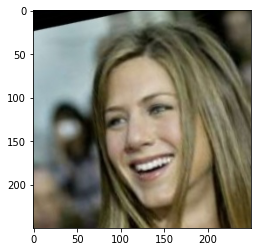

In [8]:
img = torchvision.io.read_image(p.data[8072]).numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))

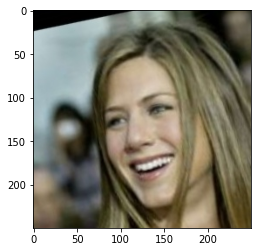

In [9]:
ii = np.array(Image.open(p.data[8072]))
plt.imshow(ii)

In [10]:
# base_transform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(112), torchvision.transforms.Normalize(0.5, 0.5)])
base_transform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(112)]) # come interagisce normalize con la divisione per 255?

class LFWP(torchvision.datasets.LFWPeople):
    def __init__(self, root: str, split: str = "10fold", image_set: str = "funneled", transform = torchvision.transforms.GaussianBlur(9, 4), target_transform = None, download: bool = False,
                 base_transform = base_transform, device = None): # default funneled
        super().__init__(root, split, image_set, transform, target_transform, download)
        self.base_transform = base_transform
        self.normalize_transform = torchvision.transforms.Normalize(0.5, 0.5)
        self.device = device


    def __getitem__(self, index: int):
        img       = self.base_transform(torchvision.io.read_image(path = self.data[index]) / 255)
        noisy_img = self.transform(img)

        # Luca normalizza entrambe alla fine
        img, noisy_img = self.normalize_transform(img), self.normalize_transform(noisy_img)

        if self.device is not None:
            img, noisy_img = img.to(self.device), noisy_img.to(self.device)

        return img, noisy_img

    def plot(self, index, figsize = (10, 5)):
        img, noisy_img = self[index]
        img = np.transpose(img.cpu().numpy(), (1, 2, 0))
        noisy_img = np.transpose(noisy_img.cpu().numpy(), (1, 2, 0))

        # Luca (necessario per compensare i valori negativi introdotti dalla normaliz.)
        img = img * 0.5 + 0.5
        noisy_img = noisy_img * 0.5 + 0.5

        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = figsize)

        ax[0].imshow(img)
        ax[1].imshow(noisy_img)

        ax[0].set_title('original')
        ax[1].set_title('transformed')

        return ax

In [11]:
w = LFWP('./lfw_torch')

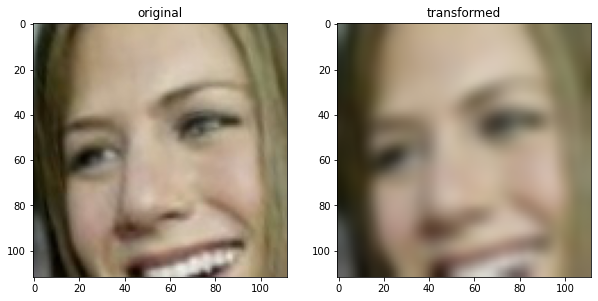

In [12]:
w.plot(8072);

In [13]:
# from skimage.filters import gaussian

In [14]:
# gaussian(np.transpose((w[8072][0]).numpy(), (1, 2, 0)), sigma = 4, channel_axis = 2)

In [15]:
# np.transpose((w[8072][1]).numpy(), (1, 2, 0))

## Datasets
Tecnicamente siccome non facciamo cross validation va bene il validation statico anziché rifarlo ogni volta; rifaccio però la funzione perché così se mi serve posso cambiare la batch size come iperparametro del modello

In [16]:
test_dataset  = LFWP('./lfw_torch/', split = 'test', device = 'cuda')
train_dataset = LFWP('./lfw_torch/', split = 'train', device = 'cuda')

In [17]:
def create_train_val_dataloaders(tr_dataset, batch_size: int, training_frac = 0.8, num_workers: int = 0, seed: int = 1234):
    n_train = int(len(tr_dataset) * training_frac)
    n_val   = len(tr_dataset) - n_train
    train, val = random_split(tr_dataset, [n_train, n_val], torch.Generator().manual_seed(seed))

    torch.random.manual_seed(seed)
    torch.cuda.random.manual_seed(seed)

    return DataLoader(train, batch_size, shuffle = True, num_workers = num_workers), DataLoader(val, batch_size, shuffle = False, num_workers = num_workers)

In [18]:
class VAE0(nn.Module): # semplificata, solo relu e adam
    def __init__(self, latent_space_dim: int, initial_lr: float, batch_size: int, dropout: float = None, l1_reg_strength: float = None, l2_reg_strength: float = None,
                loss_fn = nn.MSELoss(reduction = 'sum'), device = 'cuda'):
        super().__init__()
        self.latent_space_dim = latent_space_dim
        self.device = device
        self.dropout = dropout

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size = 4, stride = 3, padding = 1), #out = (8, 14, 14)
            nn.ReLU(),
            nn.Dropout2d(self.dropout) if dropout is not None else nn.Identity(),
            nn.Conv2d(8, 16, kernel_size = 3, stride = 2, padding = 1), #out = (16, 7, 7)
            nn.ReLU(),
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 0), #out = (32, 3, 3)
            nn.ReLU(),
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Conv2d(32, 32, kernel_size = 3, stride = 2, padding = 0), #out = (32, 3, 3)
            nn.ReLU(),
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Flatten(start_dim = 1)
        )
        # 288 = 3*3*32
        self.decoder = nn.Sequential( 
            nn.Linear(self.latent_space_dim, 112),
            nn.ReLU(),
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Linear(112, 512), # 288
            nn.ReLU(),
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Unflatten(dim = 1, unflattened_size = (32, 4, 4)),
            nn.ConvTranspose2d(32, 32, kernel_size = 3, stride = 2, output_padding = 0),
            nn.ReLU(),
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 2, output_padding = 0),
            nn.ReLU(),
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.ConvTranspose2d(16, 8, kernel_size = 3, stride = 2, padding = 1, output_padding = 0),
            nn.ReLU(),
            nn.Dropout2d(self.dropout) if dropout is not None else nn.Identity(),
            nn.ConvTranspose2d(8, 3, kernel_size = 4, stride = 3, padding = 1, output_padding = 2),
            nn.Sigmoid() #-> [0,1] output
        )

        self.avg = nn.Sequential( # Predicts the means of a MVN dist.
            nn.Linear(512, 112), # 288
            nn.ReLU(),
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Linear(112, self.latent_space_dim)
        )

        self.log_var = nn.Sequential( # Predicts the (log) variances of an uncorrelated MVN (i.e. log of cov. matrix diagonal)
            nn.Linear(512, 112), # 288
            nn.ReLU(),
            nn.Dropout(self.dropout) if dropout is not None else nn.Identity(),
            nn.Linear(112, self.latent_space_dim)
        )

        self.optimizer = torch.optim.Adam(params = self.parameters(), lr = initial_lr)
        
        self.batch_size = batch_size
        self.loss_fn = loss_fn
        self.l1_reg_strength = l1_reg_strength
        self.l2_reg_strength = l2_reg_strength

        if l1_reg_strength is None and l2_reg_strength is None:
            self.reg = lambda: torch.tensor([0], dtype = float, requires_grad = True).to(self.device)
        if l1_reg_strength is not None:
            self.reg = lambda: (sum(((w.abs()).sum() for w in self.parameters()))*self.l1_reg_strength).to(self.device)
        if l2_reg_strength is not None:
            self.reg = lambda: (sum(((w**2).sum() for w in self.parameters()))*self.l2_reg_strength).to(self.device)

    def sample_in_latent_space(self, mu, log_var): # sampling from MVN in latent space with provided mean and variances
        sigma = torch.exp(0.5 * log_var) #log_var is log(variance) = log(sigma**2) = 2 * log(sigma)
        return mu + torch.randn_like(mu) * sigma
        #Var(aX) = a**2 Var(X), so we need to multiply pred_sqrt_var = sigma (square root of the variance) by the standard normal distribution

    def forward(self, x):
        internal_repr  = self.encoder(x) # conv. part --> produces the internal representation
        pred_means     = self.avg(internal_repr) # linear part 1 --> predicts means
        pred_log_var   = self.log_var(internal_repr) # linear part 2 --> predicts variances
        sample         = self.sample_in_latent_space(mu = pred_means, log_var = pred_log_var) # sample in latent space
        decoded_sample = self.decoder(sample) # decoder --> produces final output
        
        return decoded_sample, pred_means, pred_log_var # we need to pass means and vars forward too, since they're needed to compute the KL div. term in the loss

    def train_single_epoch(self, train_dataloader, verbose_single_epoch: bool = True): # function to be iterated inside the fit loop (no cv)
        self.train() # enable dropout etc.
        tr_err_single_epoch = 0
        # SOLO BLURRED O PIXELATED
        loading = tqdm(train_dataloader) if verbose_single_epoch else train_dataloader
        for orig_batch, noisy_batch in loading: # ignore y_batch, we don't need the labels
            output, mu, log_var = self(noisy_batch)
            loss                = self.loss_fn(output, orig_batch) + self.reg() - 0.5 * torch.sum(1. + log_var - mu**2 - torch.exp(log_var))
            loss /= len(orig_batch)
            self.optimizer.zero_grad() # reset gradients
            loss.backward() # backpropagation
            self.optimizer.step() # update weights
            tr_err_single_epoch += loss.detach().cpu().numpy() # save current training error
        
        tr_err_single_epoch /= len(train_dataloader) # len of a dataloader = n. of batches
        return tr_err_single_epoch

    @torch.no_grad()
    def val_single_epoch(self, val_dataloader):
        self.eval() # disable dropout etc.
        val_err_single_epoch = 0

        for orig_batch, noisy_batch in val_dataloader: # ignore y_batch, we don't need the labels
            output, mu, log_var   = self(noisy_batch)
            loss                  = nn.MSELoss()(output, orig_batch) # we compare the reconstructed output with the original input
            val_err_single_epoch += loss.detach().cpu().numpy()
        
        val_err_single_epoch /= len(val_dataloader)
        return val_err_single_epoch

    def fit(self, training_dataset, max_n_iter: int = 15, min_n_iter: int = 3, patience: int = 4, tol: float = 0.0001, seed: int = 1234, verbose: bool = True, num_workers: int = 0):
        if seed is not None: # default seed to ensure reproducibility
            torch.random.manual_seed(seed)

        training_dataloader, validation_dataloader = create_train_val_dataloaders(training_dataset, batch_size = self.batch_size, num_workers = num_workers) # dependent on self.batch_size

        self.training_error_history, self.val_error_history = np.zeros(max_n_iter), np.zeros(max_n_iter) # no CV --> no average over dataloaders --> we have a single value to use as an estimate of tr./val. errors
        self.best_val_error = np.Inf
        patience_counter = 0

        loading = trange(max_n_iter) # if verbose else range(max_n_iter) # useful toggle during training/debugging
        for epoch in loading:
            if verbose:
                print(f'Training {epoch=}') # useful to track training
            tr_err  = self.training_error_history[epoch] = self.train_single_epoch(train_dataloader = training_dataloader)
            val_err = self.val_error_history[epoch] = self.val_single_epoch(val_dataloader = validation_dataloader)
            if verbose:
                print(f'{epoch=}: {tr_err=}, {val_err=}') # useful to track training
                self.plot_original_vs_reconstructed_sample(*(test_dataset[0])) # quel tipo con la faccia strana
                # così le fa vedere tutte alla fine

            if epoch > min_n_iter:
                if val_err > self.best_val_error + tol:
                    patience_counter += 1
                else:
                    self.best_val_error = val_err
                    patience_counter = 0
                if patience_counter > patience:
                    break
        n_executed_epochs = epoch + 1 # + 1 to go from 0, N-1 (python) to 1, N (human readable) counting scheme 
        if n_executed_epochs < max_n_iter:
            self.best_val_error_epoch = n_executed_epochs - patience_counter
        else:
            self.best_val_error_epoch = max_n_iter - patience_counter

    def save(self, root_path, model_name):
        path = f'{root_path}/{model_name}'
        torch.save(self.state_dict(), path + '.pt')
        np.savetxt(path + '_th.csv', self.training_error_history)
        np.savetxt(path + '_vh.csv', self.val_error_history)

    @torch.no_grad()
    def predict(self, sample):
        self.eval()
        if sample.shape == torch.Size([3, 112, 112]): # a single sample # torch.Size([1, 28, 28]) in origine (-> serve la dim. 0 = N)
            output = self(sample.unsqueeze(0))[0] # the forward pass computes means and variances too, but here we only want the reconstructed samples
        else:
            output = self(sample)[0]
        return output

    def test_accuracy(self, test_dataset):
        v = np.zeros(len(test_dataset))
        for i in range(len(test_dataset)):
            img, noisy_img = test_dataset[i]
            v[i] = float(nn.MSELoss()(self.predict(noisy_img), img))
        return v.mean()

    def plot_original_vs_reconstructed_sample(self, orig_sample, noisy_sample, figsize = (7, 7), return_array: bool = False):
        fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = figsize)
        img_orig = orig_sample.cpu().detach().squeeze(0).numpy().transpose((1, 2, 0))
        img_rec = self.predict(noisy_sample).cpu().detach().squeeze(0).numpy().transpose((1, 2, 0))
        img_noisy = noisy_sample.cpu().detach().numpy().transpose((1, 2, 0))

        ax[0].imshow(img_orig, cmap = 'gray')
        ax[0].set_title('Orig.')
        ax[0].axis('off')
        ax[1].imshow(img_noisy, cmap = 'gray')
        ax[1].set_title('Noisy')
        ax[1].axis('off')
        ax[2].imshow(img_rec, cmap = 'gray')
        ax[2].set_title('Rec.')
        ax[2].axis('off')

        if return_array:
            return img_rec
        else:
            return fig, ax

    
    def plot_reconstructed_samples(self, dataset, nrows: int = 3, ncols: int = 3, figsize = (42, 21)):
        indices = np.arange(nrows * ncols)
        idx = 0
        ncols = 2*ncols
        fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
        
        for i in range(nrows):
            for j in range(0, ncols, 2):
                img = dataset.data[indices[idx]]
                img_rec = self.plot_original_vs_reconstructed_sample(img, return_array = True)
                # img = img.detach().cpu().squeeze(0).numpy()
                img = img.detach().cpu().numpy().transpose((1, 2, 0))
                ax[i,j].imshow(img, cmap = 'gray')
                ax[i,j].set_title('Orig.')
                ax[i,j].axis('off')
                ax[i,j+1].imshow(img_rec, cmap = 'gray')
                ax[i,j+1].set_title('Rec.')
                ax[i,j+1].axis('off')
                idx += 1

        return fig, ax

In [19]:
model0 = VAE0(64, 1e-3, 8).cuda() # il tipo usa batch size = 8 e 15 epoche, mentre Luca ne usa 30. Sistema sopra/nella chiamata a .fit()

  0%|          | 0/15 [00:00<?, ?it/s]

Training epoch=0


100%|██████████| 953/953 [01:20<00:00, 11.90it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  7%|▋         | 1/15 [01:35<22:16, 95.49s/it]

epoch=0: tr_err=array([7052.59907918]), val_err=0.16579283334345998
Training epoch=1


100%|██████████| 953/953 [00:40<00:00, 23.64it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 13%|█▎        | 2/15 [02:22<14:30, 67.00s/it]


epoch=1: tr_err=array([6101.00216568]), val_err=0.16192943406404312
Training epoch=2


100%|██████████| 953/953 [00:40<00:00, 23.41it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 20%|██        | 3/15 [03:09<11:36, 58.05s/it]

epoch=2: tr_err=array([5966.17006779]), val_err=0.15787526107856917
Training epoch=3


100%|██████████| 953/953 [00:40<00:00, 23.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 27%|██▋       | 4/15 [03:57<09:51, 53.79s/it]


epoch=3: tr_err=array([5806.83737548]), val_err=0.15332304717481884
Training epoch=4


100%|██████████| 953/953 [00:42<00:00, 22.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 33%|███▎      | 5/15 [04:47<08:44, 52.47s/it]


epoch=4: tr_err=array([5674.44849545]), val_err=0.1505466903166292
Training epoch=5


100%|██████████| 953/953 [01:09<00:00, 13.71it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 40%|████      | 6/15 [06:10<09:27, 63.07s/it]


epoch=5: tr_err=array([5586.73202594]), val_err=0.1486435938455071
Training epoch=6


100%|██████████| 953/953 [00:39<00:00, 24.18it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 47%|████▋     | 7/15 [06:56<07:39, 57.44s/it]


epoch=6: tr_err=array([5530.3411238]), val_err=0.1473541720517011
Training epoch=7


100%|██████████| 953/953 [00:38<00:00, 24.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 53%|█████▎    | 8/15 [07:41<06:13, 53.41s/it]

epoch=7: tr_err=array([5483.50483247]), val_err=0.14632255016635154
Training epoch=8


100%|██████████| 953/953 [00:38<00:00, 24.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 60%|██████    | 9/15 [08:26<05:03, 50.65s/it]


epoch=8: tr_err=array([5449.60833341]), val_err=0.14593350503858663
Training epoch=9


100%|██████████| 953/953 [00:38<00:00, 24.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 67%|██████▋   | 10/15 [09:10<04:03, 48.70s/it]


epoch=9: tr_err=array([5418.76414919]), val_err=0.14513361447775214
Training epoch=10


100%|██████████| 953/953 [00:44<00:00, 21.58it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 73%|███████▎  | 11/15 [10:01<03:17, 49.29s/it]


epoch=10: tr_err=array([5398.14623357]), val_err=0.14452847183748269
Training epoch=11


100%|██████████| 953/953 [00:39<00:00, 24.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 80%|████████  | 12/15 [10:47<02:24, 48.24s/it]


epoch=11: tr_err=array([5380.1152062]), val_err=0.14416357503899968
Training epoch=12


100%|██████████| 953/953 [00:39<00:00, 24.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 87%|████████▋ | 13/15 [11:32<01:34, 47.48s/it]

epoch=12: tr_err=array([5366.86677252]), val_err=0.14378282686531793
Training epoch=13


100%|██████████| 953/953 [00:39<00:00, 24.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 93%|█████████▎| 14/15 [12:18<00:46, 46.90s/it]


epoch=13: tr_err=array([5353.8346795]), val_err=0.1437074066642438
Training epoch=14


100%|██████████| 953/953 [00:38<00:00, 24.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 15/15 [13:03<00:00, 52.25s/it]

epoch=14: tr_err=array([5344.526056]), val_err=0.1432384143439297


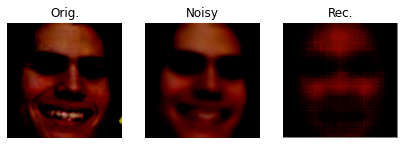

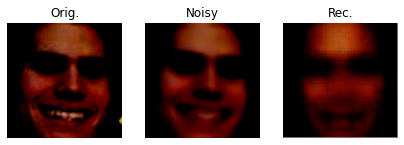

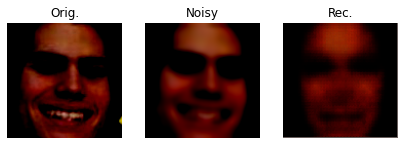

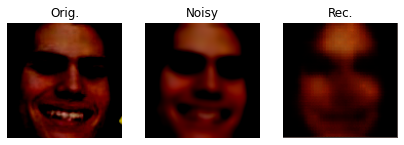

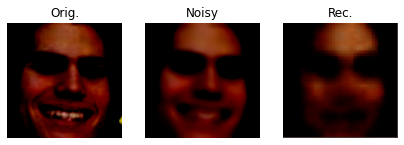

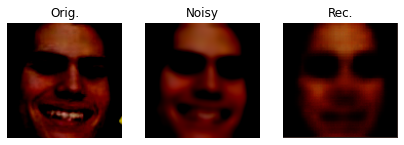

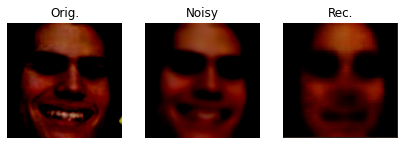

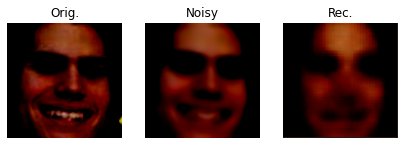

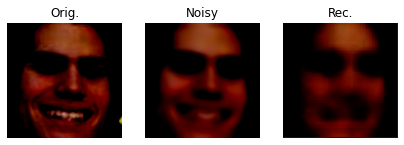

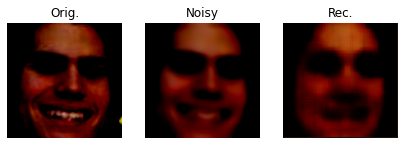

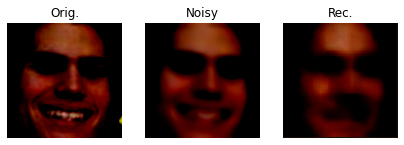

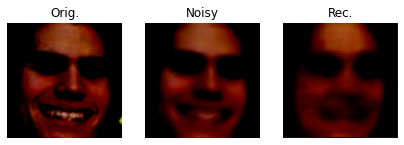

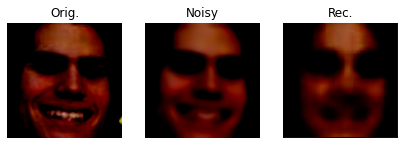

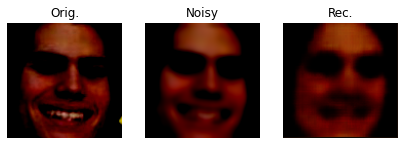

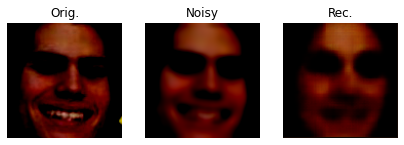

In [20]:
model0.fit(train_dataset)